[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/figs_10_11_12_13.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/deJong_Mackay_et_al_2023/figs_10_11_12_13.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/figs_10_11_12_13.ipynb)

#### based on Fig. 1 from Shipway & Hill 2012 (Q. J. Royal Meteo. Soc. 138)  "_Diagnosis of systematic differences between multiple parametrizations of warm rain microphysics using a kinematic framework_"   
https://doi.org/10.1002/qj.1913

Including BREAKUP process to demonstrate physical changes to cloud.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples>=3.0.0-pre.5')

In [2]:
from PySDM_examples.deJong_Mackay_et_al_2023 import Settings1D, Simulation1D, plot_ax, plot_zeros_ax
from PySDM.physics import si
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
import os

In [3]:
def gen_key(*, breakup, stochastic_breakup):
    return f"b={breakup}_s={stochastic_breakup}"

In [4]:
save = False
restore_saved_data = False

common_params = {
    "n_sd_per_gridbox": 256 if 'CI' not in os.environ else 32,
    "dt": 5 * si.s,
    "dz": 100 * si.m,
    "p0": 990 * si.hPa,
    "kappa": .9,
    "particles_per_volume_STP": 50 / si.cm**3,
    "precip": True,
    "rho_times_w_1": 6 * si.kg/si.m**3 * si.m/si.s,
    "output_every_n_steps": 6,
    "z_max": 5000 * si.m,
    "t_max": 3600 * si.s,
    "save_spec_at": [0.0, 300.0, 600.0, 900.0, 1200.0, 1800.0, 2700.0],
}

if restore_saved_data:
    settings = {}
    for breakup_flag in (False, True):
        for stochastic_breakup_flag in (True, False) if breakup_flag else (False,):
            key = gen_key(breakup=breakup_flag, stochastic_breakup=stochastic_breakup_flag)
            settings[key] = Settings1D(
                **common_params,
                breakup=breakup_flag,
                stochastic_breakup=stochastic_breakup_flag,
                old_buggy_density_formula=True, # just to match what was in the paper!
            )
    import pickle as pkl
    with open('data1d.pkl','rb') as file:
        output = pkl.load(file)
else:
    output = {}
    settings = {}
    simulation = {}
    for breakup_flag in (False, True):
        for stochastic_breakup_flag in (True, False) if breakup_flag else (False,):
            key = gen_key(breakup=breakup_flag, stochastic_breakup=stochastic_breakup_flag)
            settings[key] = Settings1D(
                **common_params,
                breakup=breakup_flag,
                stochastic_breakup=stochastic_breakup_flag,
                old_buggy_density_formula=True, # just to match what was in the paper!
            )
            simulation[key] = Simulation1D(settings[key])
            output[key] = simulation[key].run().products

if save:
    import pickle as pkl
    with open('data1d.pkl','wb') as file:
        pkl.dump(output, file)

## Plotting

In [5]:
contour_lev = [.4]
rate_unit = "s$^{-1}$ kg$^{-1}$"
inline_format='png'
contour_args = {
    'contour_var1': 'cloud water mixing ratio', 'contour_lvl1': contour_lev,
    'contour_var2': 'rain water mixing ratio', 'contour_lvl2': contour_lev
}
kwargs = {
    'cloud water mixing ratio':        {'cmin': 0.0, 'cmax': 4.0, 'var': 'cloud water mixing ratio',               'qlabel': '$q_c$ [g/kg]'     },
    'rain water mixing ratio':        {'cmin': 0.0, 'cmax': 4.0, 'var': 'rain water mixing ratio',               'qlabel': '$q_r$ [g/kg]'     },
    'na':        {'cmin': 0.0, 'cmax': 5e7, 'var': 'na',               'qlabel': '$n_a$ [m$^{-3}$]' },
    'coll_rate': {'cmin': 100, 'cmax': 1e6, 'var': 'collision_rate',   'qlabel': f'collision rate [{rate_unit}]', 'clog': True}, 
    'coal_rate': {'cmin': 100, 'cmax': 1e6, 'var': 'coalescence_rate', 'qlabel': f'coalescence rate [{rate_unit}]', 'clog': True},
    'brkp_rate': {'cmin': 1, 'cmax': 1e4, 'var': 'breakup_rate',     'qlabel': f'breakup rate [{rate_unit}]', 'clog': True},
    'brkp_zero': {'cmin': 1, 'cmax': 1e4, 'var': 'coalescence_rate', 'qlabel': f'breakup rate [{rate_unit}]', 'clog': True},
    'rpng_rate': {'cmin': 1e0, 'cmax': 1e6, 'var': 'ripening',         'qlabel': f'ripening rate [{rate_unit}]'    , 'clog': True},
    'actv_rate': {'cmin': 1e0, 'cmax': 1e6, 'var': 'activating',       'qlabel': f'activating rate [{rate_unit}]'  , 'clog': True},
    'dctv_rate': {'cmin': 1e0, 'cmax': 1e6, 'var': 'deactivating',     'qlabel': f'deactivating rate [{rate_unit}]', 'clog': True},
    'N(v)':      {'cmin': 0.0}
}

def add_titles(ax):
    ax[0][0].text(1500, 7.0, 'No Breakup', weight='bold',)
    ax[0][1].text(1000, 7.0, 'Property-Independent Breakup', weight='bold')
    ax[0][2].text(1000, 7.0, 'Property-Dependent Breakup', weight='bold')

def add_ylabels_qn(ax):
    ax[0][0].text(-750, 0.5, 'Cloud Liquid Water (g/kg)', rotation='vertical', weight='bold')
    ax[1][0].text(-750, 0.5, 'Rain Liquid Water (g/kg)', rotation='vertical', weight='bold')
    ax[2][0].text(-750, 0.5, 'Aerosol Concentration (m$^{-3}$)', rotation='vertical',weight='bold')

def add_ylabels_rates(ax, rates):
    ax[0][0].text(-750, 0.5, f'{rates[0]} Rate [{rate_unit}]', rotation='vertical', weight='bold')
    ax[1][0].text(-750, 0.5, f'{rates[1]} Rate [{rate_unit}]', rotation='vertical', weight='bold')
    ax[2][0].text(-750, 0.5, f'{rates[2]} Rate [{rate_unit}]', rotation='vertical', weight='bold')

def plot_spectra(ax, key_arg, t_sel):
    spct_step = common_params['save_spec_at'].index(t_sel)
    ax.step(settings[key_arg].r_bins_edges[0:-1] / si.um, output[key_arg]['dvdlnr'].mean(axis=0)[:,spct_step] / si.cm**3,label=str(spct_step))
    ax.set_xscale('log')
    ax.set_xlim([1e0, 1e4])
    ax.set_xlabel(r"particle radius ($\mu$m)")
    ax.set_ylabel('dm / dlnr  (g / m$^3$)')
    ax.set_title('t = ' + str(t_sel) + 's')

def add_spectra_legend(ax):
    ax.legend(['No Breakup', 'Property-Independent', 'Property-Dependent'])
    
def fig_ax():
    return plt.subplots(nrows=3, ncols=3, figsize=(16,12))

def fig_ax_spectra():
    return plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,6))

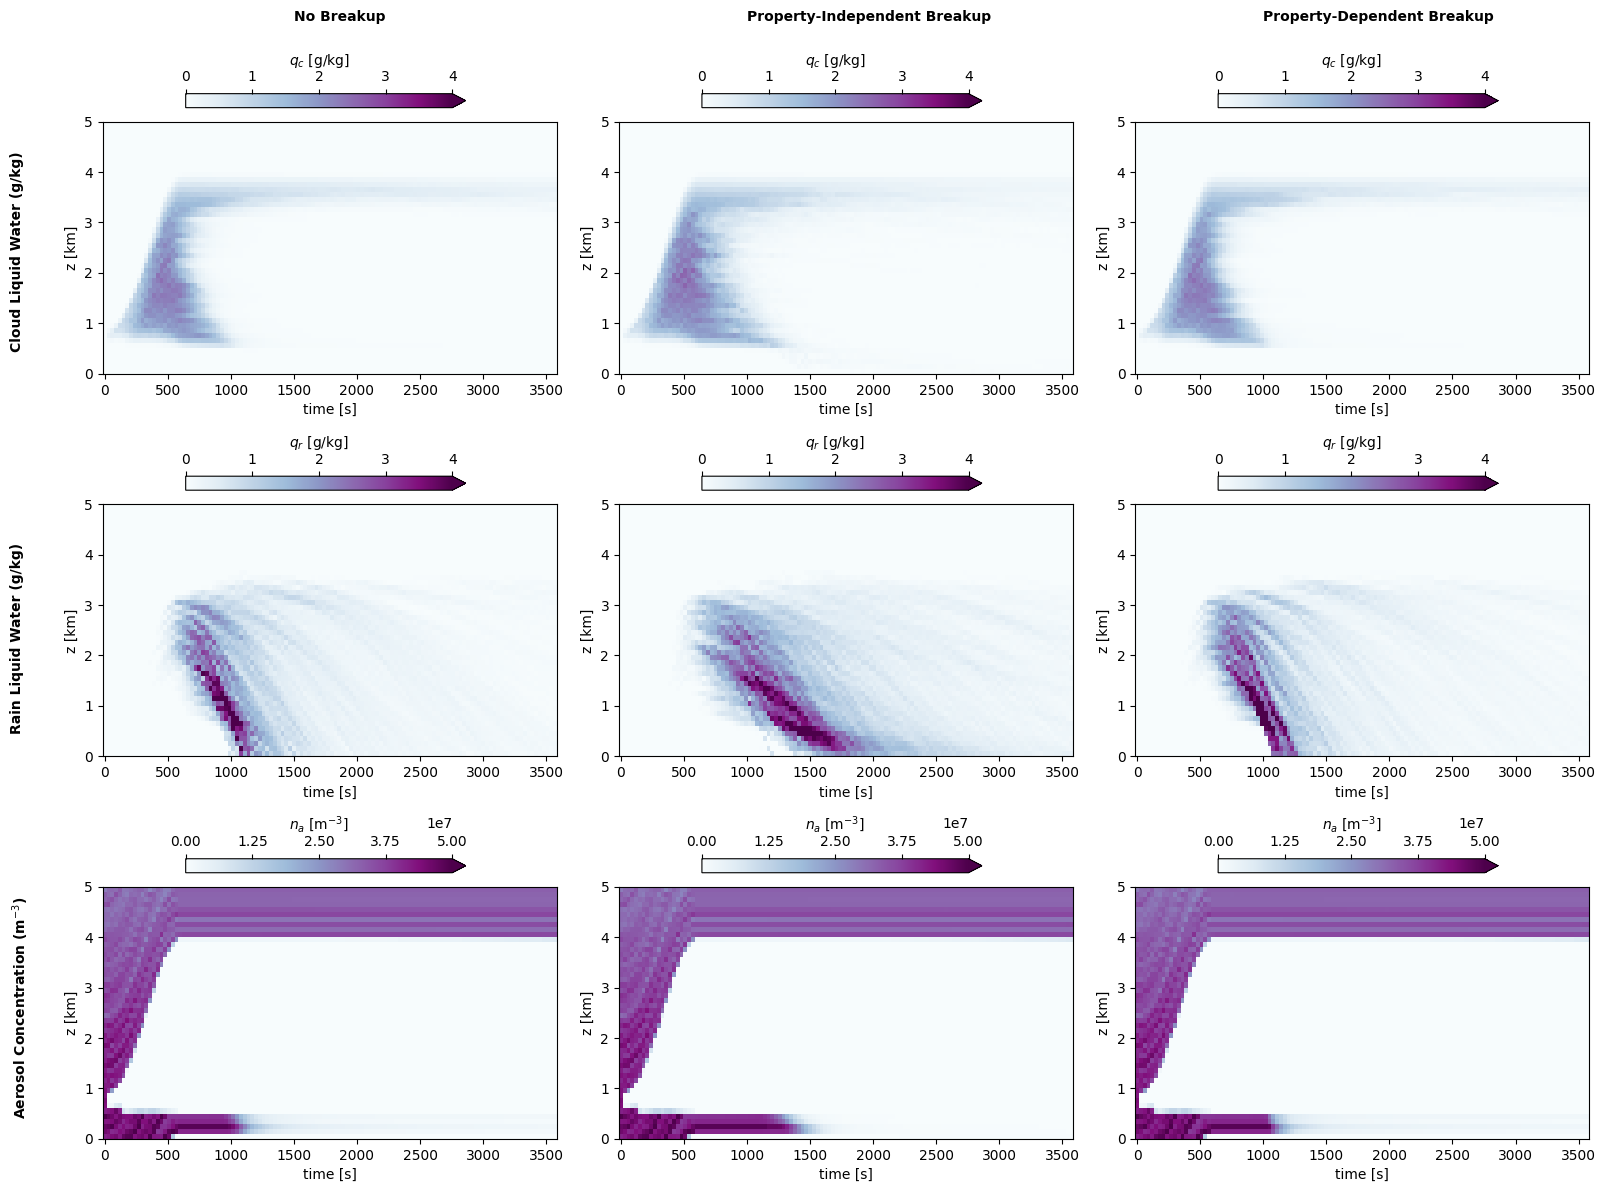

In [6]:
# Hydrometeors
fig, axes = fig_ax()

key = gen_key(breakup=False, stochastic_breakup=False)
plot_ax(axes[0][0], output=output[key], **kwargs['cloud water mixing ratio'])
plot_ax(axes[1][0], output=output[key], **kwargs['rain water mixing ratio'])
plot_ax(axes[2][0], output=output[key], **kwargs['na'])

key = gen_key(breakup=True, stochastic_breakup=False)
plot_ax(axes[0][1], output=output[key], **kwargs['cloud water mixing ratio'])
plot_ax(axes[1][1], output=output[key], **kwargs['rain water mixing ratio'])
plot_ax(axes[2][1], output=output[key], **kwargs['na'])

key = gen_key(breakup=True, stochastic_breakup=True)
plot_ax(axes[0][2], output=output[key], **kwargs['cloud water mixing ratio'])
plot_ax(axes[1][2], output=output[key], **kwargs['rain water mixing ratio'])
plot_ax(axes[2][2], output=output[key], **kwargs['na'])

add_ylabels_qn(axes)
add_titles(axes)
plt.tight_layout()
show_plot("fig10_hydrometeors.pdf", inline_format=inline_format)

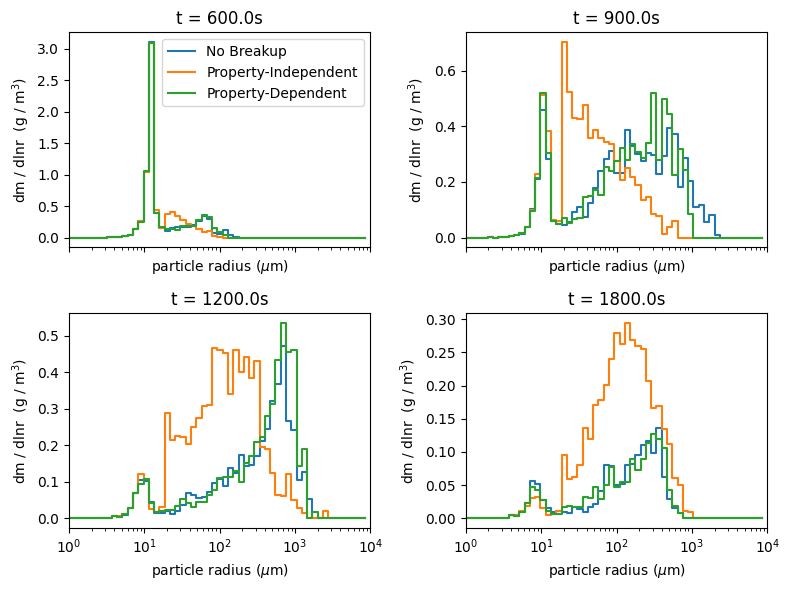

In [7]:
# Spectra
fig, axes = fig_ax_spectra()

for breakup_flag in (False, True):
    for stochastic_breakup_flag in (False, True) if breakup_flag else (False,):
        key = gen_key(breakup=breakup_flag, stochastic_breakup=stochastic_breakup_flag)

        plot_spectra(axes[0][0], key, t_sel=600 * si.s)

        plot_spectra(axes[0][1], key, t_sel=900 * si.s)

        plot_spectra(axes[1][0], key, t_sel=1200 * si.s)

        plot_spectra(axes[1][1], key, t_sel=1800 * si.s)

add_spectra_legend(axes[0][0])
plt.tight_layout()
show_plot('fig11_spectra_from_1d.pdf', inline_format = inline_format)

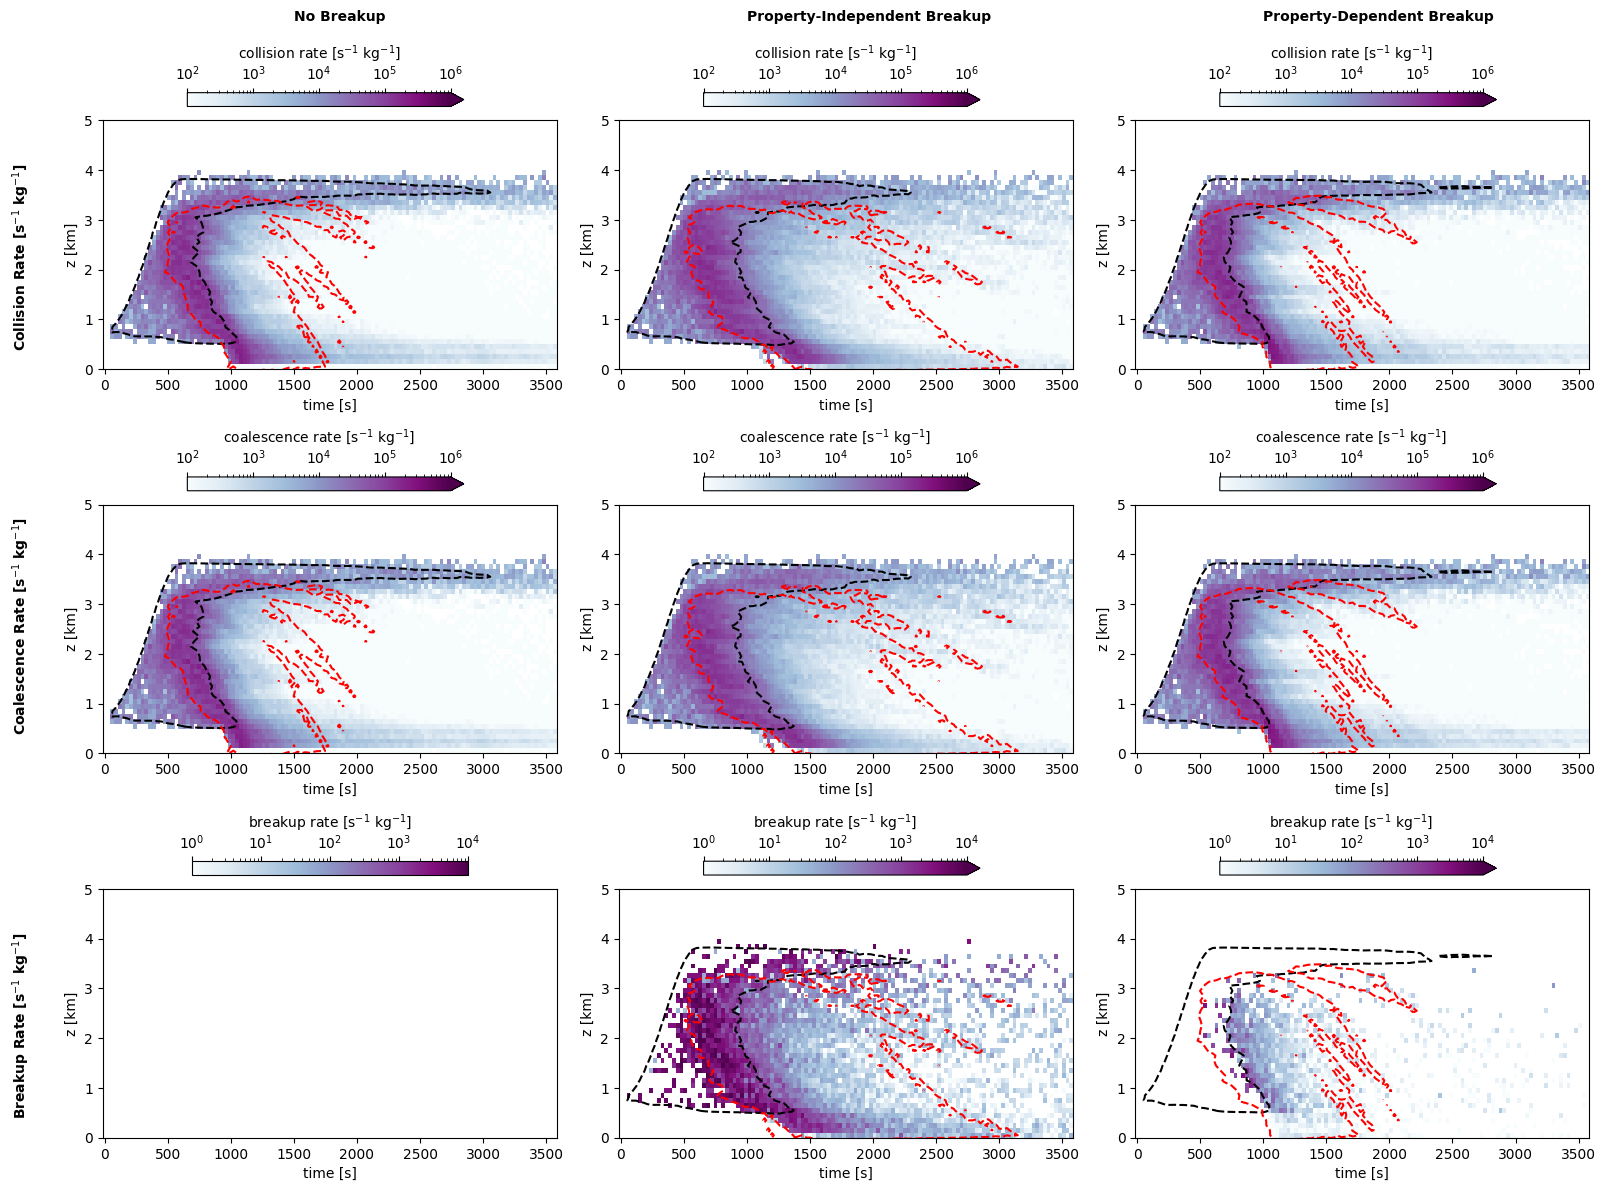

In [8]:
# Rates
fig, axes = fig_ax()

key = gen_key(breakup=False, stochastic_breakup=False)
plot_ax(axes[0][0], output=output[key], **contour_args, **kwargs['coll_rate'])
plot_ax(axes[1][0], output=output[key], **contour_args, **kwargs['coal_rate'])
plot_zeros_ax(axes[2][0], output=output[key],           **kwargs['brkp_zero'])

key = gen_key(breakup=True, stochastic_breakup=False)
plot_ax(axes[0][1], output=output[key], **contour_args, **kwargs['coll_rate'])
plot_ax(axes[1][1], output=output[key], **contour_args, **kwargs['coal_rate'])
plot_ax(axes[2][1], output=output[key], **contour_args, **kwargs['brkp_rate'])

key = gen_key(breakup=True, stochastic_breakup=True)
plot_ax(axes[0][2], output=output[key], **contour_args, **kwargs['coll_rate'])
plot_ax(axes[1][2], output=output[key], **contour_args, **kwargs['coal_rate'])
plot_ax(axes[2][2], output=output[key], **contour_args, **kwargs['brkp_rate'])

add_ylabels_rates(axes, ('Collision', 'Coalescence', 'Breakup'))
add_titles(axes)
plt.tight_layout()
show_plot("fig12_collision_rates.pdf", inline_format=inline_format)

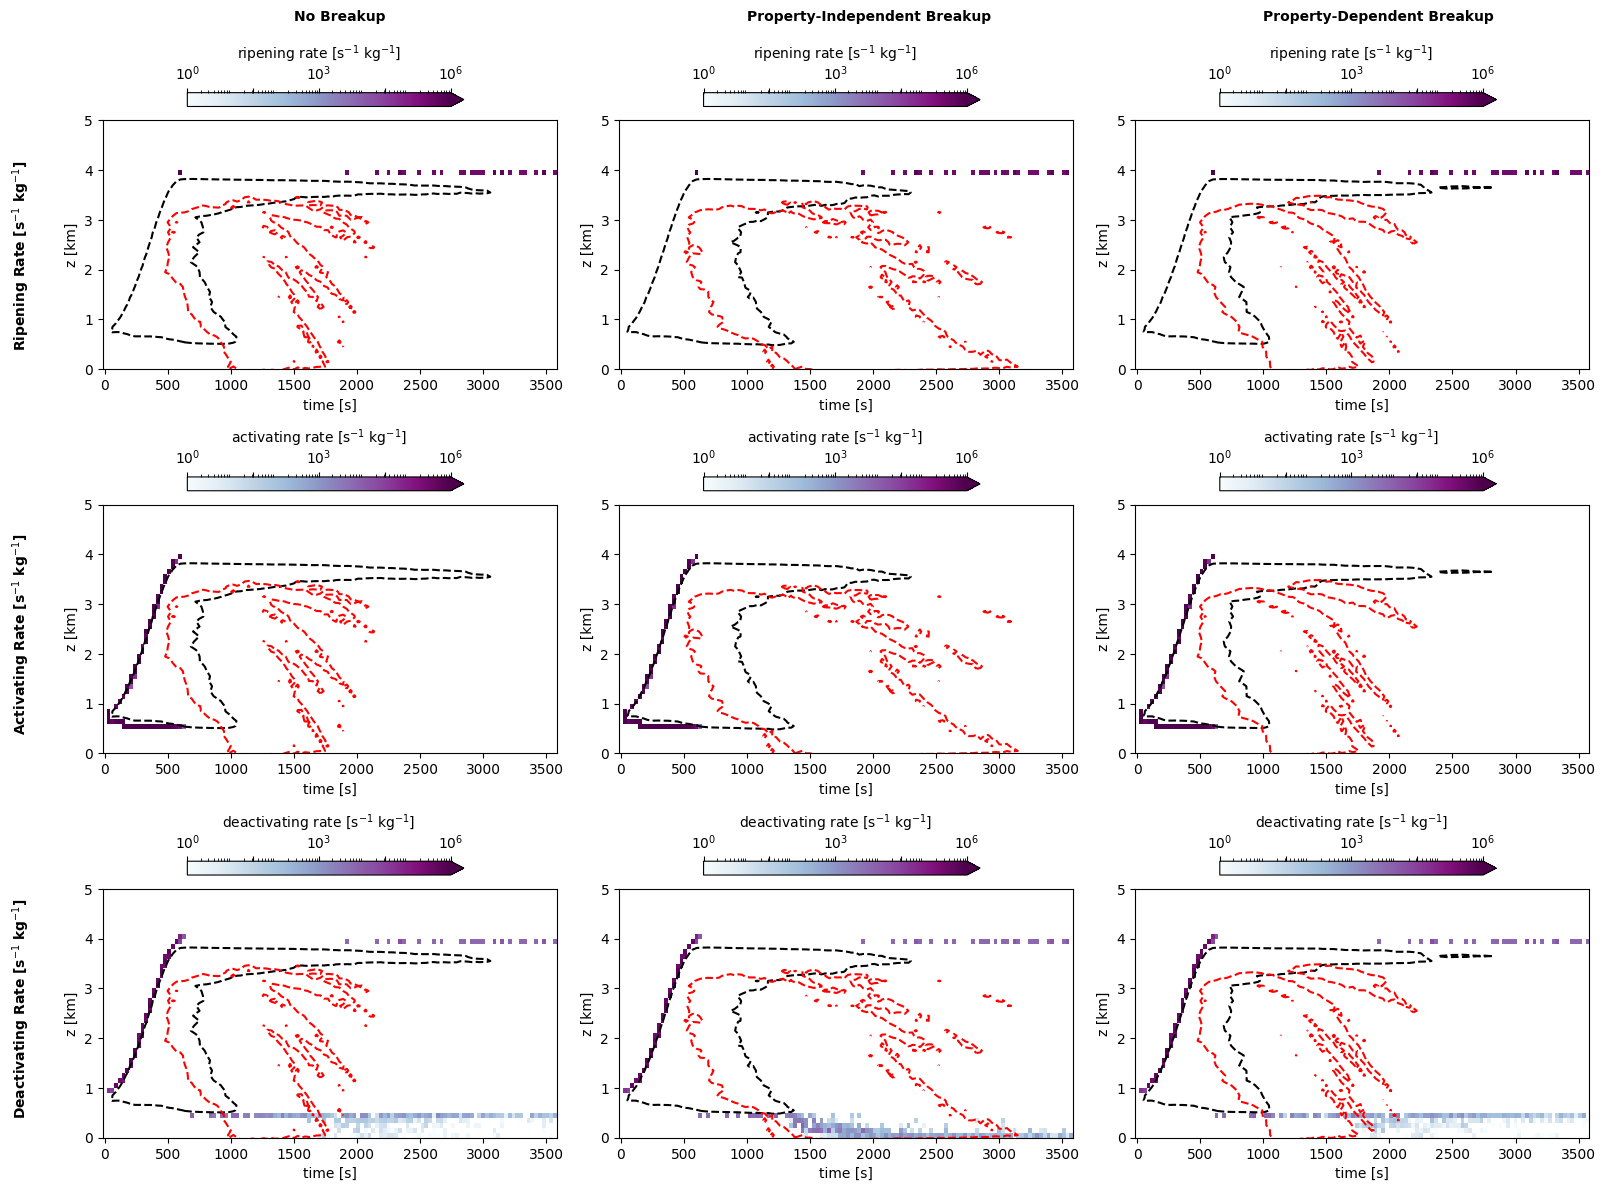

In [9]:
# Aerosol rates
fig, axes = fig_ax()

key = gen_key(breakup=False, stochastic_breakup=False)
plot_ax(axes[0][0], output=output[key], **contour_args, **kwargs['rpng_rate'])
plot_ax(axes[1][0], output=output[key], **contour_args, **kwargs['actv_rate'])
plot_ax(axes[2][0], output=output[key], **contour_args, **kwargs['dctv_rate'])

key = gen_key(breakup=True, stochastic_breakup=False)
plot_ax(axes[0][1], output=output[key], **contour_args, **kwargs['rpng_rate'])
plot_ax(axes[1][1], output=output[key], **contour_args, **kwargs['actv_rate'])
plot_ax(axes[2][1], output=output[key], **contour_args, **kwargs['dctv_rate'])

key = gen_key(breakup=True, stochastic_breakup=True)
plot_ax(axes[0][2], output=output[key], **contour_args, **kwargs['rpng_rate'])
plot_ax(axes[1][2], output=output[key], **contour_args, **kwargs['actv_rate'])
plot_ax(axes[2][2], output=output[key], **contour_args, **kwargs['dctv_rate'])

add_ylabels_rates(axes, ('Ripening', 'Activating', 'Deactivating'))
add_titles(axes)
plt.tight_layout()
show_plot("fig13_aerosol_rates.pdf", inline_format=inline_format)